# Analysez des données de systèmes éducatifs

Importation des modules nécessaires à notre analyse.

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.impute import KNNImputer

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import missingno as msno

import pygal

In [2]:
print('pandas version : ', pd.__version__, '\n')
print('numpy version : ', np.__version__, '\n')
print('sklearn version : ', np.__version__, '\n')
print('matplotlib version : ', matplotlib.__version__, '\n')
print('seaborn version : ', sns.__version__, '\n')
print('missingno version : ', msno.__version__, '\n')
print('pygal version : ', pygal.__version__)

pandas version :  1.2.4 

numpy version :  1.20.1 

sklearn version :  1.20.1 

matplotlib version :  3.3.4 

seaborn version :  0.11.1 

missingno version :  0.5.0 

pygal version :  2.4.0


Importation et première analyse des jeux de données.

In [3]:
ed_stats_data = pd.read_csv('EdStatsData.csv')
ed_stats_country = pd.read_csv('EdStatsCountry.csv')
ed_stats_country_series = pd.read_csv('EdStatsCountry-Series.csv')
ed_stats_footnote = pd.read_csv('EdStatsFootNote.csv')
ed_stats_series = pd.read_csv('EdStatsSeries.csv')

In [4]:
liste_df = [ed_stats_data, ed_stats_country, ed_stats_country_series, ed_stats_footnote, ed_stats_series]

for df in liste_df:
    print(df.shape,'\n')
    print(df.columns)

(886930, 70) 

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978',
       '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987',
       '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996',
       '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005',
       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2020', '2025', '2030', '2035', '2040', '2045',
       '2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090',
       '2095', '2100', 'Unnamed: 69'],
      dtype='object')
(241, 32) 

Index(['Country Code', 'Short Name', 'Table Name', 'Long Name', '2-alpha code',
       'Currency Unit', 'Special Notes', 'Region', 'Income Group', 'WB-2 code',
       'National accounts base year', 'National accounts reference year',
       'SNA price valuation', 'Lending category', 

Dans un premier temps, nous allons garder les données numériques de *ed_stats_data* comprises entre 1970 et 2030.  A la lecture des colonnes des autres jeux de données, nous n'allons garder que les colonnes "Region", "Country Code" et "Income Group" de *ed_stats_country*.

In [5]:
ed_stats_data_dropped = ed_stats_data.drop(columns = ['Indicator Code', '1970', '1971', '1972', '1973', '1974',\
                                                      '1975', '1976', '1977', '1978', '1979',\
                                                      '1980', '1981', '1982', '1983', '1984',\
                                                      '1985', '1986', '1987', '1988', '1989',\
                                                      '2035', '2040', '2045', '2050', '2055',\
                                                      '2060', '2065', '2070', '2075', '2080',\
                                                      '2085', '2090', '2095', '2100', 'Unnamed: 69'])

In [6]:
ed_stats_country_dropped = \
ed_stats_country.drop(columns = ['Short Name', 'Table Name', 'Long Name', '2-alpha code', 'Currency Unit',\
                                 'Special Notes', 'WB-2 code', 'National accounts base year',\
                                 'National accounts reference year', 'SNA price valuation',\
                                 'Lending category', 'Other groups', 'System of National Accounts',\
                                 'Alternative conversion factor', 'PPP survey year',\
                                 'Balance of Payments Manual in use', 'External debt Reporting status',\
                                 'System of trade', 'Government Accounting concept',\
                                 'IMF data dissemination standard', 'Latest population census',\
                                 'Latest household survey', 'Source of most recent Income and expenditure data',\
                                 'Vital registration complete', 'Latest agricultural census',\
                                 'Latest industrial data', 'Latest trade data',\
                                 'Latest water withdrawal data', 'Unnamed: 31'])

In [7]:
#On joint les deux jeux de données sur 'Country Code'

df_merged = ed_stats_data_dropped.merge(ed_stats_country_dropped, on = 'Country Code', how = 'left')

print(df_merged.columns, '\n')
print(df_merged.shape)

Index(['Country Name', 'Country Code', 'Indicator Name', '1990', '1991',
       '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000',
       '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
       '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2020',
       '2025', '2030', 'Region', 'Income Group'],
      dtype='object') 

(886930, 36)


## Choix des indicateurs et gestion des données manquantes

En allant sur le site de la Banque Mondiale, nous avons décidé de garder 6 indicateurs :
- Population growth (annual %),
- Population, total,
- Government expenditure on education as % of GDP (%),
- GDP per capita, PPP (current international $),
- Internet users (per 100 people),
- Enrolment in tertiary education, all programmes, both sexes (number).

In [8]:
df_merged = df_merged.set_index('Indicator Name')

In [9]:
df_merged = df_merged.loc[["Population growth (annual %)","Population, total",\
                           "Government expenditure on education as % of GDP (%)",\
                           "GDP per capita, PPP (current international $)","Internet users (per 100 people)",\
                           "Enrolment in tertiary education, all programmes, both sexes (number)"],:] 

In [10]:
df_merged.reset_index(inplace=True)
df_merged['Indicator Name'].unique()

array(['Population growth (annual %)', 'Population, total',
       'Government expenditure on education as % of GDP (%)',
       'GDP per capita, PPP (current international $)',
       'Internet users (per 100 people)',
       'Enrolment in tertiary education, all programmes, both sexes (number)'],
      dtype=object)

Vérifions si nous avons des duplicatas dans nos données.

In [11]:
df_merged.duplicated().sum()

0

Voyons maintenant combien de données manquantes nous avons dans notre jeu de données :

In [12]:
print(df_merged.info(),'\n')
print(df_merged.isnull().mean())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1452 entries, 0 to 1451
Data columns (total 36 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Indicator Name  1452 non-null   object 
 1   Country Name    1452 non-null   object 
 2   Country Code    1452 non-null   object 
 3   1990            1096 non-null   float64
 4   1991            913 non-null    float64
 5   1992            926 non-null    float64
 6   1993            942 non-null    float64
 7   1994            977 non-null    float64
 8   1995            1053 non-null   float64
 9   1996            1086 non-null   float64
 10  1997            1033 non-null   float64
 11  1998            1098 non-null   float64
 12  1999            1183 non-null   float64
 13  2000            1182 non-null   float64
 14  2001            1180 non-null   float64
 15  2002            1202 non-null   float64
 16  2003            1184 non-null   float64
 17  2004            1199 non-null   f

<AxesSubplot:>

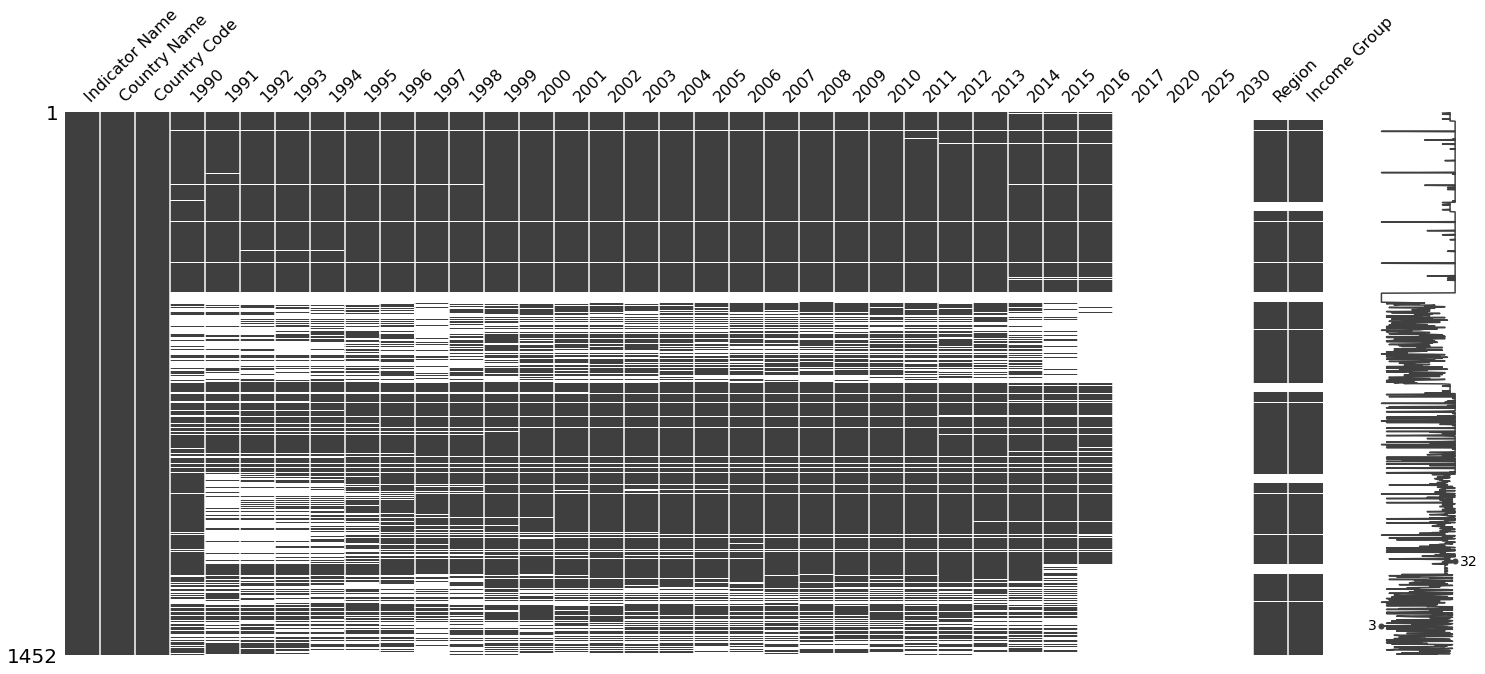

In [13]:
msno.matrix(df_merged)

Nous allons supprimer les colonnes avec plus de 30% de valeurs manquantes ainsi que les colonnes "1995" à "1999" car l'indicateur "Internet users (per 100 people)" aurait peu d'intérêt.

Nous en profitons pour supprimer "Country Code" et "Indicator Code" que nous n'allons plus utiliser.

In [14]:
df_merged = df_merged.drop(columns = ['Country Code', '1990', '1991','1992', '1993', '1994',\
                                      '1995', '1996','1997','1998','1999','2016', '2017', '2020',\
                                      '2025', '2030'])

In [15]:
print(df_merged.info(),'\n')
print(df_merged.isnull().mean())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1452 entries, 0 to 1451
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Indicator Name  1452 non-null   object 
 1   Country Name    1452 non-null   object 
 2   2000            1182 non-null   float64
 3   2001            1180 non-null   float64
 4   2002            1202 non-null   float64
 5   2003            1184 non-null   float64
 6   2004            1199 non-null   float64
 7   2005            1183 non-null   float64
 8   2006            1182 non-null   float64
 9   2007            1190 non-null   float64
 10  2008            1205 non-null   float64
 11  2009            1206 non-null   float64
 12  2010            1215 non-null   float64
 13  2011            1213 non-null   float64
 14  2012            1197 non-null   float64
 15  2013            1191 non-null   float64
 16  2014            1132 non-null   float64
 17  2015            1054 non-null   f

Regardons le noms des pays des valeurs manquantes de la colonne "Region", elles ont l'air de suivre un pattern.

In [16]:
df_merged[df_merged['Region'].isnull()]['Country Name'].unique()

array(['Arab World', 'East Asia & Pacific',
       'East Asia & Pacific (excluding high income)', 'Euro area',
       'Europe & Central Asia',
       'Europe & Central Asia (excluding high income)', 'European Union',
       'Heavily indebted poor countries (HIPC)', 'High income',
       'Latin America & Caribbean',
       'Latin America & Caribbean (excluding high income)',
       'Least developed countries: UN classification',
       'Low & middle income', 'Low income', 'Lower middle income',
       'Middle East & North Africa',
       'Middle East & North Africa (excluding high income)',
       'Middle income', 'North America', 'OECD members', 'South Asia',
       'Sub-Saharan Africa', 'Sub-Saharan Africa (excluding high income)',
       'Upper middle income', 'World', 'British Virgin Islands',
       'Gibraltar', 'Nauru'], dtype=object)

On peut remarquer que les valeurs manquantes ne correspondent pas à des pays à proprement parler mais à des zones géographiques et à des petits territoires.  Nous supprimons toutes ces lignes.

In [17]:
df_merged = df_merged.dropna(subset=['Region'], axis=0)

Comme les lignes avec beaucoup de valeurs manquantes ne nous intéressent pas, nous allons les supprimer.  Mais, regardons d'abord l'effet que cela aurait sur notre Dataframe.

In [18]:
df_merged.shape

(1284, 20)

In [19]:
df_test = df_merged.copy()

Regardons le nombre de lignes restantes selon le threshold (le nombre de valeurs non nulles) que nous imposons.

In [20]:
for val in range(17):
    df_test.dropna(axis=0, thresh = val, inplace = True)
    print("Avec un threshold de",val,"le dataframe aurait {} lignes".format(df_test.shape[0]))

Avec un threshold de 0 le dataframe aurait 1284 lignes
Avec un threshold de 1 le dataframe aurait 1284 lignes
Avec un threshold de 2 le dataframe aurait 1284 lignes
Avec un threshold de 3 le dataframe aurait 1284 lignes
Avec un threshold de 4 le dataframe aurait 1284 lignes
Avec un threshold de 5 le dataframe aurait 1199 lignes
Avec un threshold de 6 le dataframe aurait 1178 lignes
Avec un threshold de 7 le dataframe aurait 1165 lignes
Avec un threshold de 8 le dataframe aurait 1148 lignes
Avec un threshold de 9 le dataframe aurait 1128 lignes
Avec un threshold de 10 le dataframe aurait 1111 lignes
Avec un threshold de 11 le dataframe aurait 1096 lignes
Avec un threshold de 12 le dataframe aurait 1080 lignes
Avec un threshold de 13 le dataframe aurait 1059 lignes
Avec un threshold de 14 le dataframe aurait 1037 lignes
Avec un threshold de 15 le dataframe aurait 1021 lignes
Avec un threshold de 16 le dataframe aurait 1008 lignes


Nous allons garder un threshold à 10 (soit 6 valeurs manquantes au maximum par ligne) afin de limiter la perte de lignes et de ne pas à avoir à remplacer trop de valeurs.

In [21]:
df_merged.dropna(axis=0, thresh = 10, inplace=True)
df_merged.shape

(1111, 20)

<AxesSubplot:>

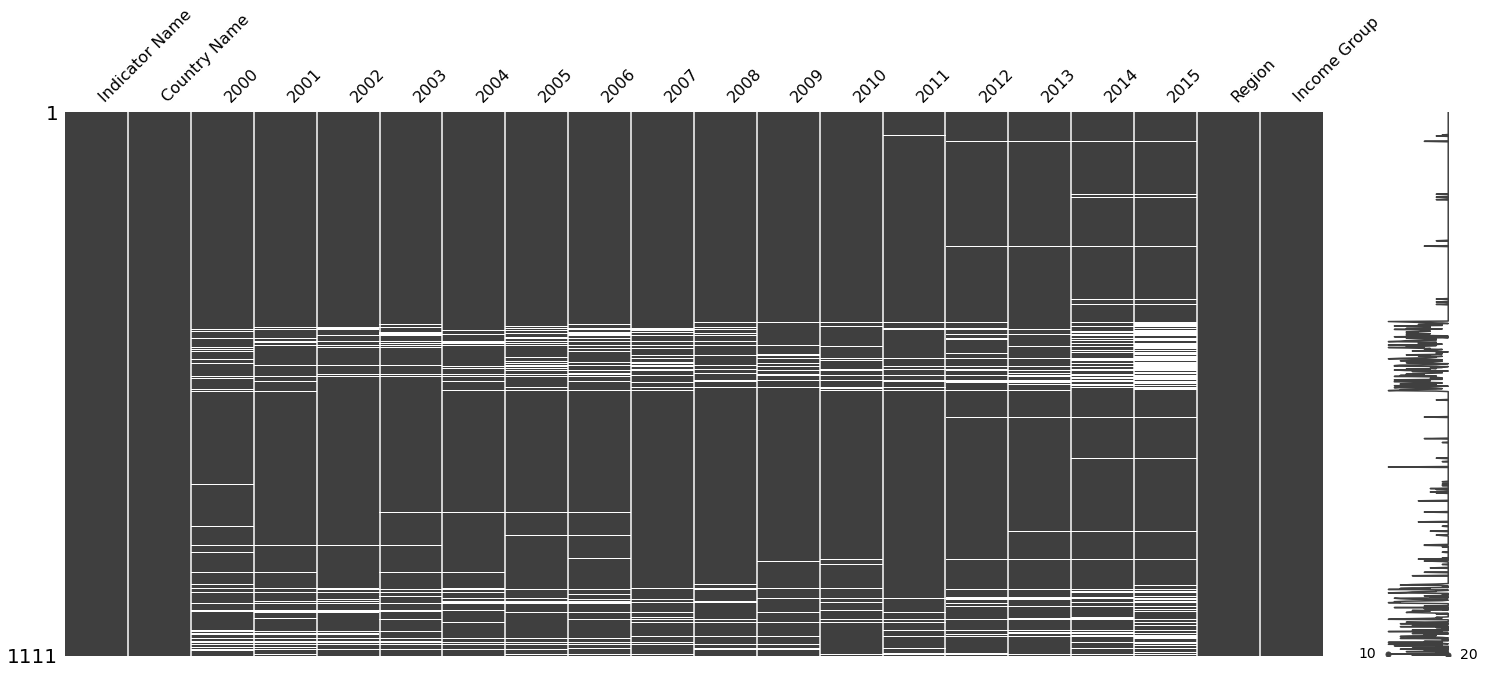

In [22]:
msno.matrix(df_merged)

Nous allons regarder quelques lignes en particulier pour voir si notre imputer remplit convenablement les valeurs manquantes, lorsque nous l'aurons mis en place.

In [23]:
df_merged_verif = df_merged.copy()
df_merged_verif.sort_values(by='2000', inplace=True)

In [24]:
df_merged_verif.head(3)

,Indicator Name,Country Name,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,Region,Income Group
75,Population growth (annual %),Curacao,-4.075386,-3.771878,-0.078383,1.883489,1.594798,2.477253,2.534396,1.983521,1.350729,0.631919,2.317847,0.867561,0.954188,0.945169,NaN,NaN,Latin America & Caribbean,High income: nonOECD
129,Population growth (annual %),Kosovo,-3.582128,0.067859,0.067931,0.067885,0.067839,0.067910,0.803200,0.803262,0.803213,0.803172,0.803249,0.859067,0.789727,1.041533,-0.126169,-1.103886,Europe & Central Asia,Lower middle income
207,Population growth (annual %),St. Martin (French part),-3.193254,-2.143728,-1.202216,-0.317443,0.550323,1.414675,1.804026,1.713261,1.616342,1.500129,1.382088,1.248989,1.117366,0.980353,NaN,NaN,Latin America & Caribbean,High income: nonOECD


Nous allons utiliser KNNImputer pour remplir les dernières valeurs manquantes de notre jeu de données.

Dans la mesure où nous travaillons avec des années, nous allons pondérer les valeurs voisines des valeurs manquantes par leur distance à celles-ci.

In [25]:
liste_annees = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010',\
                '2011','2012','2013','2014','2015']

imputer = KNNImputer(n_neighbors = 10, weights = 'distance')
array = imputer.fit_transform(df_merged.loc[:,liste_annees])

In [26]:
df_inter = pd.DataFrame(array)

In [27]:
df_inter.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,3.494659,4.251504,4.720528,4.818041,4.468918,3.870470,3.228630,2.755225,2.512574,2.569114,2.812617,3.095119,3.272703,3.315224,3.183201,2.943234
1,-0.637357,-0.938470,-0.299877,-0.374149,-0.417931,-0.511790,-0.630911,-0.755719,-0.767343,-0.673894,-0.496462,-0.269017,-0.165151,-0.183211,-0.207047,-0.291206
2,1.349663,1.301453,1.267231,1.268580,1.310924,1.383398,1.459709,1.534038,1.621298,1.720717,1.821358,1.924787,2.006614,2.036092,2.000666,1.919959
3,1.314208,1.130561,0.951199,0.655083,0.248351,-0.246659,-0.794787,-1.281838,-1.519175,-1.418038,-1.054862,-0.571394,-0.162822,0.139320,0.234776,0.180222
4,1.572166,2.939992,3.942573,4.375449,4.098923,3.382417,2.657515,2.067598,1.414665,0.714106,-0.015393,-0.829969,-1.588653,-2.013314,-1.956178,-1.537836


In [28]:
df_inter.rename(columns = {0:'2000',1:'2001',2:'2002',3:'2003',4:'2004',5:'2005',6:'2006',\
                           7:'2007',8:'2008',9:'2009',10:'2010',11:'2011',12:'2012',\
                           13:'2013',14:'2014',15:'2015'}, inplace=True)

In [29]:
for val in liste_annees:
    df_merged[val] = df_inter[val].values

In [30]:
df_merged.isnull().sum()

Indicator Name    0
Country Name      0
2000              0
2001              0
2002              0
2003              0
2004              0
2005              0
2006              0
2007              0
2008              0
2009              0
2010              0
2011              0
2012              0
2013              0
2014              0
2015              0
Region            0
Income Group      0
dtype: int64

Comparons à notre *df_merged_verif*.

In [31]:
df_merged_verif_2 = df_merged.copy()
df_merged_verif_2.sort_values('2000',inplace=True)

In [32]:
print(df_merged_verif.head(3),'\n')
print(df_merged_verif_2.head(3))

                   Indicator Name              Country Name      2000  \
75   Population growth (annual %)                   Curacao -4.075386   
129  Population growth (annual %)                    Kosovo -3.582128   
207  Population growth (annual %)  St. Martin (French part) -3.193254   

         2001      2002      2003      2004      2005      2006      2007  \
75  -3.771878 -0.078383  1.883489  1.594798  2.477253  2.534396  1.983521   
129  0.067859  0.067931  0.067885  0.067839  0.067910  0.803200  0.803262   
207 -2.143728 -1.202216 -0.317443  0.550323  1.414675  1.804026  1.713261   

         2008      2009      2010      2011      2012      2013      2014  \
75   1.350729  0.631919  2.317847  0.867561  0.954188  0.945169       NaN   
129  0.803213  0.803172  0.803249  0.859067  0.789727  1.041533 -0.126169   
207  1.616342  1.500129  1.382088  1.248989  1.117366  0.980353       NaN   

         2015                     Region          Income Group  
75        NaN  Latin Ame

## Suppression des indicateurs inutiles et/ou redondants

Nous cherchons à savoir si quelques uns de nos indicateurs sont corrélés entre eux.

In [33]:
df_indicateurs_a_supprimer = df_merged.copy()

In [34]:
df_indicateurs_a_supprimer.isnull().sum()

Indicator Name    0
Country Name      0
2000              0
2001              0
2002              0
2003              0
2004              0
2005              0
2006              0
2007              0
2008              0
2009              0
2010              0
2011              0
2012              0
2013              0
2014              0
2015              0
Region            0
Income Group      0
dtype: int64

In [35]:
df_indicateurs_a_supprimer['Indicator Name'].unique()

array(['Population growth (annual %)', 'Population, total',
       'Government expenditure on education as % of GDP (%)',
       'GDP per capita, PPP (current international $)',
       'Internet users (per 100 people)',
       'Enrolment in tertiary education, all programmes, both sexes (number)'],
      dtype=object)

In [36]:
df_indicateurs_a_supprimer = df_indicateurs_a_supprimer.groupby('Indicator Name').mean()

La valeur moyenne de chaque indicateur par année ne nous importe pas, nous cherchons juste à voir l'évolution globale de chaque indicateur entre 2000 et 2015.

In [37]:
df_indicateurs_a_supprimer = df_indicateurs_a_supprimer.transpose()

In [38]:
df_indicateurs_a_supprimer.corr(method = 'pearson')

Indicator Name,"Enrolment in tertiary education, all programmes, both sexes (number)","GDP per capita, PPP (current international $)",Government expenditure on education as % of GDP (%),Internet users (per 100 people),Population growth (annual %),"Population, total"
Indicator Name,,,,,,
"Enrolment in tertiary education, all programmes, both sexes (number)",1.000000,0.987418,0.860674,0.995721,-0.538172,0.997478
"GDP per capita, PPP (current international $)",0.987418,1.000000,0.789586,0.982544,-0.438794,0.988164
Government expenditure on education as % of GDP (%),0.860674,0.789586,1.000000,0.855750,-0.661221,0.851586
Internet users (per 100 people),0.995721,0.982544,0.855750,1.000000,-0.577512,0.999147
Population growth (annual %),-0.538172,-0.438794,-0.661221,-0.577512,1.000000,-0.548386
"Population, total",0.997478,0.988164,0.851586,0.999147,-0.548386,1.000000


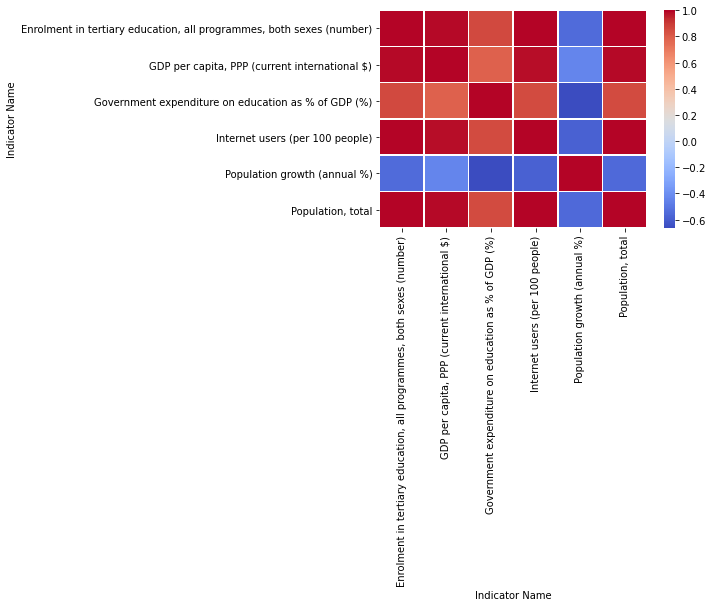

In [39]:
h = sns.heatmap(df_indicateurs_a_supprimer.corr(), linewidth = 0.5, cmap="coolwarm")

Nous allons uniquement supprimer "Government expenditure on education as % of GDP (%)" et "Enrolment in tertiary education, all programmes, both sexes (number)".

"Population, total", "Internet users (per 100 people)" et "GDP per capita, PPP (current international $)" sont aussi très liés les uns aux autres mais nous allons tout de même les garder pour notre analyse.  Cela permettra de mettre en avant des pays avec une nombre important d'utilisateurs d'internet.

In [40]:
df_final = df_merged.copy()
df_final = df_final.set_index('Indicator Name')
df_final.drop(labels = ['Enrolment in tertiary education, all programmes, both sexes (number)',\
                        'Government expenditure on education as % of GDP (%)'], axis = 0, inplace = True)

In [41]:
df_final = df_final.reset_index()
df_final['Indicator Name'].unique()

array(['Population growth (annual %)', 'Population, total',
       'GDP per capita, PPP (current international $)',
       'Internet users (per 100 people)'], dtype=object)

## Le Scoring

Nous allons diviser notre jeu de données en 4 (une partie par indicateur) et associer une note comprise entre 0 et 100 (basée sur le percentile de la valeur dans la colonne) par pays et par année.

In [42]:
subset_1 = df_final.copy()
subset_1 = subset_1.set_index('Indicator Name')
subset_1 = subset_1.loc['Population growth (annual %)',:]

In [43]:
subset_2 = df_final.copy()
subset_2 = subset_2.set_index('Indicator Name')
subset_2 = subset_2.loc['Population, total',:]

In [44]:
subset_3 = df_final.copy()
subset_3 = subset_3.set_index('Indicator Name')
subset_3 = subset_3.loc['GDP per capita, PPP (current international $)',:]

In [45]:
subset_4 = df_final.copy()
subset_4 = subset_4.set_index('Indicator Name')
subset_4 = subset_4.loc['Internet users (per 100 people)',:]

Nous allons regarder nos premières lignes pour *subset_1* et *subset_2* afin de vérifier que notre technique de scoring fonctionne convenablement.

In [46]:
subset_1.sort_values(by=['2000'], ascending=False).head(3)

,Country Name,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,Region,Income Group
Indicator Name,,,,,,,,,,,,,,,,,,,
Population growth (annual %),Rwanda,5.539102,3.714288,2.452438,1.674486,1.578337,1.946107,2.361262,2.582134,2.722791,2.735945,2.664241,2.593510,2.560881,2.528715,2.500797,2.474095,Sub-Saharan Africa,Low income
Population growth (annual %),Turks and Caicos Islands,5.494481,6.720743,7.430612,7.391741,6.683192,5.518534,4.415581,3.546799,2.894165,2.558489,2.446276,2.350048,2.182063,2.066019,1.887949,1.762730,Latin America & Caribbean,High income: nonOECD
Population growth (annual %),United Arab Emirates,5.430624,5.281528,5.304712,6.477493,8.843692,11.356439,13.510585,14.236792,13.161466,10.615444,7.587098,4.743700,2.594796,1.181805,0.714763,0.915608,Middle East & North Africa,High income: nonOECD


In [47]:
subset_2.sort_values(by=['2000'], ascending=False).head(3)

,Country Name,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,Region,Income Group
Indicator Name,,,,,,,,,,,,,,,,,,,
"Population, total",China,1.262645e+09,1.271850e+09,1.280400e+09,1.288400e+09,1.296075e+09,1.303720e+09,1.311020e+09,1.317885e+09,1.324655e+09,1.331260e+09,1.337705e+09,1.344130e+09,1.350695e+09,1.357380e+09,1.364270e+09,1.371220e+09,East Asia & Pacific,Upper middle income
"Population, total",India,1.053051e+09,1.071478e+09,1.089807e+09,1.108028e+09,1.126136e+09,1.144119e+09,1.161978e+09,1.179681e+09,1.197147e+09,1.214270e+09,1.230981e+09,1.247236e+09,1.263066e+09,1.278562e+09,1.293859e+09,1.309054e+09,South Asia,Lower middle income
"Population, total",United States,2.821624e+08,2.849690e+08,2.876252e+08,2.901079e+08,2.928053e+08,2.955166e+08,2.983799e+08,3.012312e+08,3.040940e+08,3.067715e+08,3.093482e+08,3.116634e+08,3.139984e+08,3.162049e+08,3.185635e+08,3.208966e+08,North America,High income: OECD


In [48]:
subsets = [subset_1, subset_2, subset_3, subset_4]

for i in liste_annees:
    for j in subsets:
        j[i] = j[i].rank(pct=True)*100

In [49]:
subset_1.sort_values(by=['2000'], ascending=False).head(3)

,Country Name,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,Region,Income Group
Indicator Name,,,,,,,,,,,,,,,,,,,
Population growth (annual %),Rwanda,100.000000,94.859813,76.168224,60.280374,58.411215,67.289720,73.831776,78.037383,82.242991,84.112150,80.841121,80.373832,81.308411,82.710280,82.242991,81.308411,Sub-Saharan Africa,Low income
Population growth (annual %),Turks and Caicos Islands,99.532710,100.000000,100.000000,100.000000,99.065421,98.598131,98.130841,93.925234,87.383178,79.906542,78.971963,78.037383,71.962617,71.495327,69.158879,64.953271,Latin America & Caribbean,High income: nonOECD
Population growth (annual %),United Arab Emirates,99.065421,99.532710,99.532710,99.532710,99.532710,99.532710,99.532710,99.532710,99.532710,99.532710,99.532710,97.663551,81.775701,49.065421,33.177570,39.252336,Middle East & North Africa,High income: nonOECD


In [50]:
subset_2.sort_values(by=['2000'], ascending=False).head(3)

,Country Name,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,Region,Income Group
Indicator Name,,,,,,,,,,,,,,,,,,,
"Population, total",China,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,East Asia & Pacific,Upper middle income
"Population, total",India,99.532710,99.532710,99.532710,99.532710,99.532710,99.532710,99.532710,99.532710,99.532710,99.532710,99.532710,99.532710,99.532710,99.532710,99.532710,99.532710,South Asia,Lower middle income
"Population, total",United States,99.065421,99.065421,99.065421,99.065421,99.065421,99.065421,99.065421,99.065421,99.065421,99.065421,99.065421,99.065421,99.065421,99.065421,99.065421,99.065421,North America,High income: OECD


Nous retrouvons bien les mêmes pays en tête d'affiche.

Nous considérons que certains indicateurs ont une importance plus grande, nous multiplions leur score par 2.  Les indicateurs concernés sont "Population, total" et "Internet users (per 100 people)".

In [51]:
for year in liste_annees:
    subset_2[year] = 2 * subset_2[year]
    subset_4[year] = 2 * subset_4[year]

In [52]:
df_concat = pd.concat([subset_1,subset_2,subset_3,subset_4])

In [53]:
df_concat = df_concat.reset_index()

Nous allons maintenant faire la moyenne, pour chaque pays et pour chaque année, du score de chaque indicateur.

In [54]:
df_mean_values = df_concat.groupby(['Country Name']).mean()
df_mean_values.head(3)

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Country Name,,,,,,,,,,,,,,,,
Afghanistan,78.383610,66.380825,66.451282,66.580765,66.814410,74.099410,74.060647,70.949397,68.044374,71.751531,72.204022,74.190003,74.177300,72.319487,72.058425,70.966946
Albania,37.102555,41.459308,39.854089,41.809775,44.066602,50.716848,53.833605,54.948310,59.037628,64.951054,65.228968,66.065674,65.454145,64.422557,63.857394,62.256451
Algeria,83.873398,83.134482,84.263943,85.603824,90.124631,90.855078,90.789764,91.210689,91.041128,91.750446,89.975709,90.307185,90.770283,91.105994,92.452247,93.114419


La moyenne que nous venons de réaliser, nous donne des scores allant de 0 à 150.  Par soucis de lisibilité, nous allons revenir à une base 100.

In [55]:
for i in liste_annees:
    df_mean_values[i] = df_mean_values[i]/150*100

In [56]:
df_mean_values.head(3)

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Country Name,,,,,,,,,,,,,,,,
Afghanistan,52.255740,44.253883,44.300854,44.387176,44.542940,49.399607,49.373765,47.299598,45.362916,47.834354,48.136014,49.460002,49.451533,48.212991,48.038950,47.311297
Albania,24.735037,27.639539,26.569392,27.873184,29.377735,33.811232,35.889070,36.632207,39.358419,43.300703,43.485979,44.043783,43.636096,42.948372,42.571596,41.504301
Algeria,55.915599,55.422988,56.175962,57.069216,60.083087,60.570052,60.526510,60.807126,60.694085,61.166964,59.983806,60.204790,60.513522,60.737329,61.634832,62.076279


## Analyse graphique

Observons premièrement la distribution des scores de 2015 pour chaque région (valeurs extrêmes exclues).

In [57]:
subset_pop_growth = df_final.copy()
subset_pop_growth = subset_pop_growth.set_index('Indicator Name')
subset_pop_growth = subset_pop_growth.loc['Population growth (annual %)',:]
subset_pop_growth = subset_pop_growth.reset_index()

In [58]:
subset_pop_total = df_final.copy()
subset_pop_total = subset_pop_total.set_index('Indicator Name')
subset_pop_total = subset_pop_total.loc['Population, total',:]
subset_pop_total = subset_pop_total.reset_index()

In [59]:
subset_GDP = df_final.copy()
subset_GDP = subset_GDP.set_index('Indicator Name')
subset_GDP = subset_GDP.loc['GDP per capita, PPP (current international $)',:]
subset_GDP = subset_GDP.reset_index()

In [60]:
subset_internet = df_final.copy()
subset_internet = subset_internet.set_index('Indicator Name')
subset_internet = subset_internet.loc['Internet users (per 100 people)',:]
subset_internet = subset_internet.reset_index()

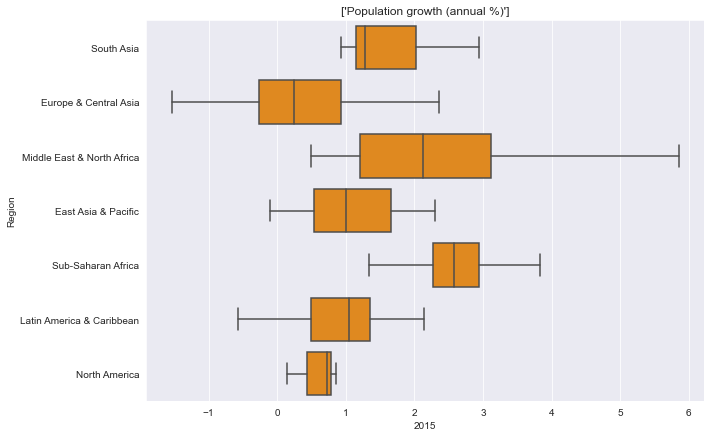

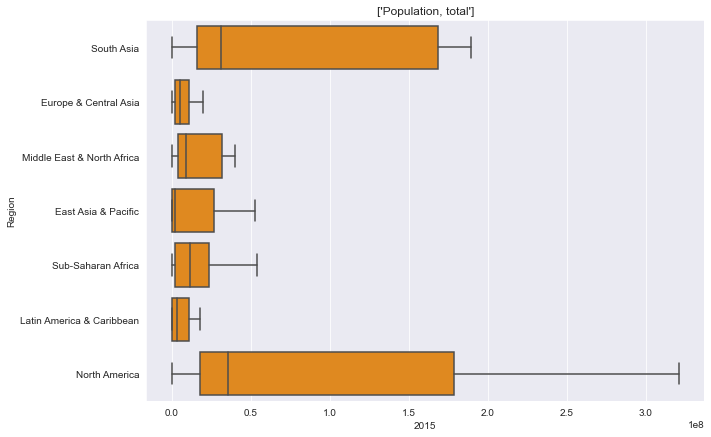

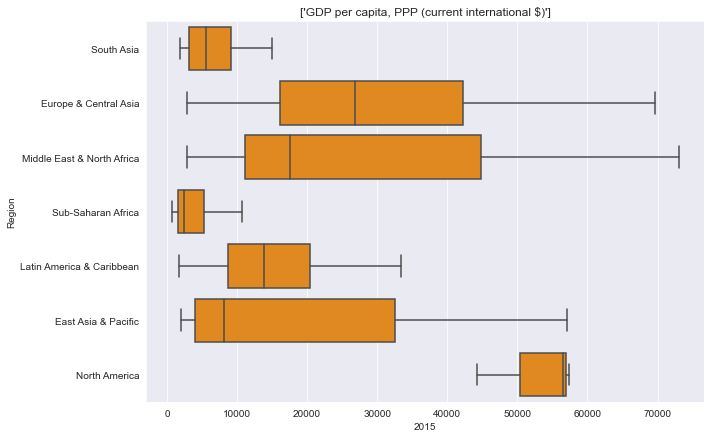

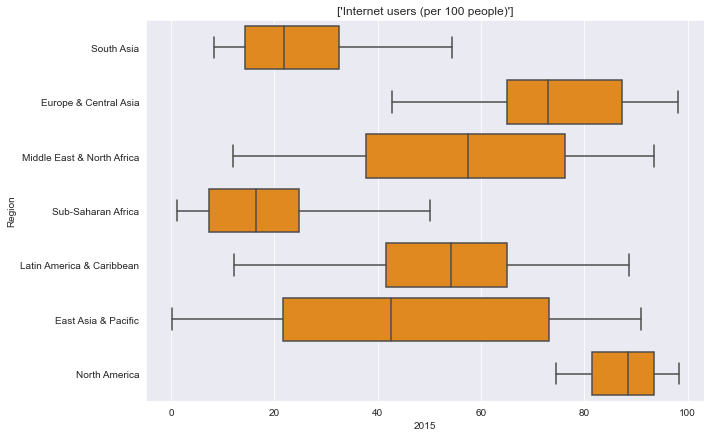

In [61]:
subsets_bis = [subset_pop_growth, subset_pop_total, subset_GDP, subset_internet]

with sns.axes_style("darkgrid"):
    for df in subsets_bis:
        plt.figure(figsize=(10, 7))
        sns.boxplot(x = '2015', y = df['Region'], data = df, color = 'darkorange', sym = "")
        plt.title(df['Indicator Name'].unique())
        plt.show()

Commençons par regarder l'évolution du score des 10 pays ayant le meilleur score en 2015.

In [62]:
df_top_20 = df_mean_values.sort_values(by='2015', ascending = False).head(20)
df_top_20_countries = df_top_20.reset_index()

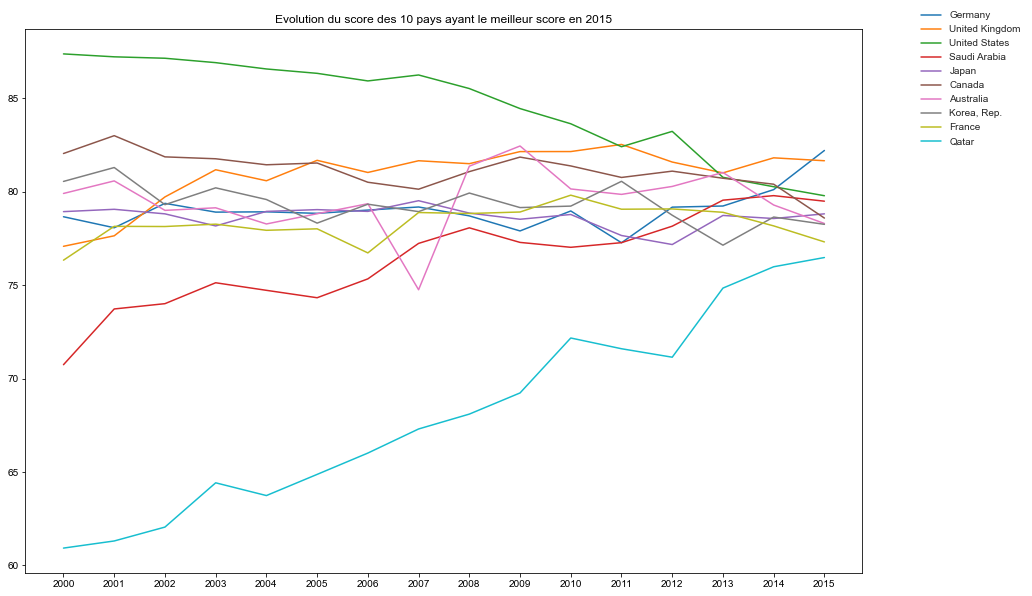

In [63]:
fig = plt.figure(figsize=(15, 10))
ax = plt.axes()
plt.title('Evolution du score des 10 pays ayant le meilleur score en 2015')
plt.style.use('seaborn-darkgrid')

for country in df_top_20_countries['Country Name'].head(10):
    ax.plot(df_top_20.loc[country], label = country)
    plt.legend(bbox_to_anchor=(1.2, 1.05))

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax = plt.axes()
plt.title('Evolution du score des 10 pays ayant le meilleur score en 2015')
plt.style.use('seaborn-darkgrid')

for country in df_top_20_countries['Country Name'].head(10):
    ax.plot(df_top_20.loc[country], label = country)
    plt.legend(bbox_to_anchor=(1.2, 1.05))

Comparons les 20 pays ayant eu le meilleur score en 2015 :

In [64]:
liste_top_pays = df_top_20_countries['Country Name']

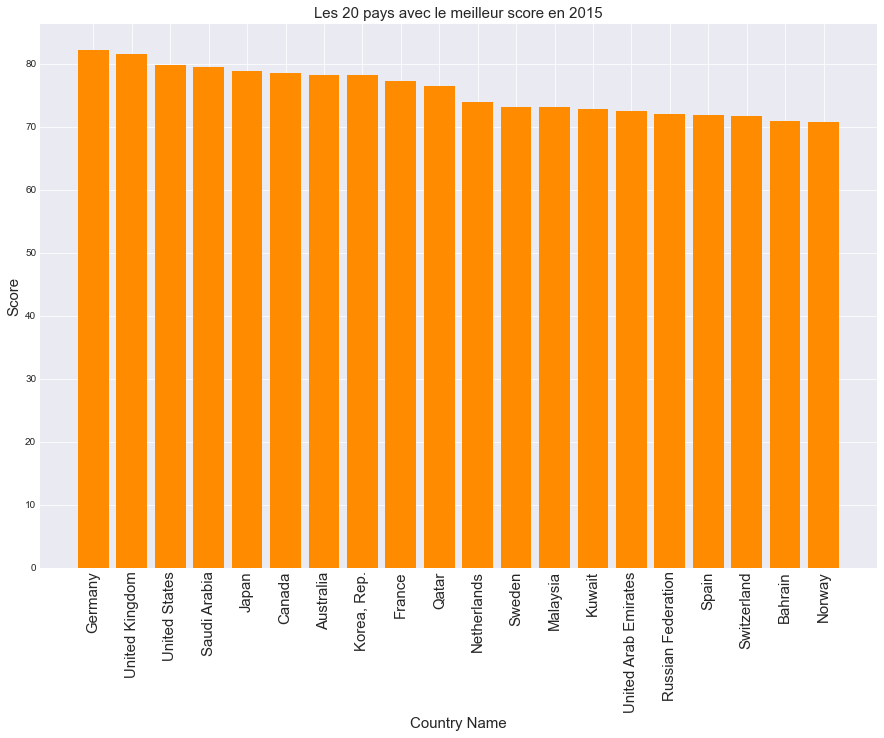

In [65]:
fig,ax = plt.subplots()

fig.set_size_inches([15,10])

ax.bar(df_top_20_countries['Country Name'], height = df_top_20_countries['2015'], color = 'darkorange')

ax.set_title('Les 20 pays avec le meilleur score en 2015', fontsize = 15)
ax.set_xlabel('Country Name', fontsize = 15)
ax.set_ylabel('Score', fontsize = 15)
xticks_loc = ax.get_xticks()

ax.xaxis.set_major_locator(mticker.FixedLocator(xticks_loc))

ax.set_xticklabels(liste_top_pays, rotation = 90, fontsize = 15)

plt.show()

Observons maintenant l'évolution du score entre 2000 et 2015 pour nos différentes régions du monde.

In [66]:
df_mean_values_region = df_concat.groupby('Region').mean(numeric_only=True)
df_mean_values_region_bis = df_mean_values_region.reset_index()

for i in liste_annees:
    df_mean_values_region[i] = df_mean_values_region[i]/150*100

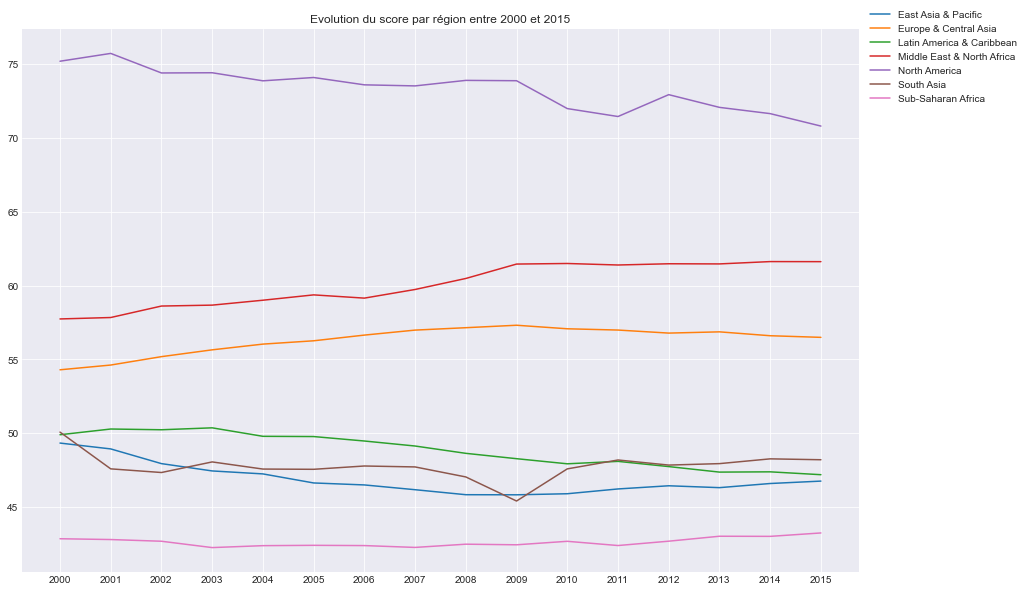

In [67]:
fig = plt.figure(figsize=(15, 10))
ax = plt.axes()
plt.title('Evolution du score par région entre 2000 et 2015')

for region in df_mean_values_region_bis['Region'].unique():
    ax.plot(df_mean_values_region.loc[region], label = region)
    plt.legend(bbox_to_anchor=(1.2, 1.05))

Qu'en est-il de l'évolution du score par Income Group entre 2000 et 2015 :

In [68]:
df_mean_values_income = df_concat.groupby('Income Group').mean(numeric_only=True)
df_mean_values_income_bis = df_mean_values_income.reset_index()

for i in liste_annees:
    df_mean_values_income[i] = df_mean_values_income[i]/150*100

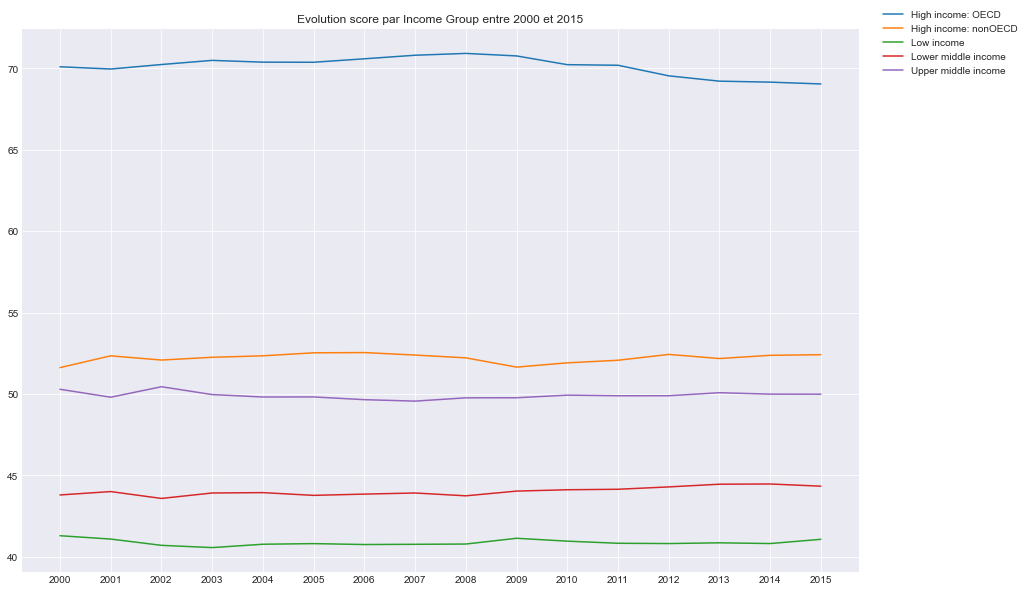

In [69]:
fig = plt.figure(figsize=(15, 10))
ax = plt.axes()
plt.title('Evolution score par Income Group entre 2000 et 2015')

for group in df_mean_values_income_bis['Income Group'].unique():
    ax.plot(df_mean_values_income.loc[group], label = group)
    plt.legend(bbox_to_anchor=(1.2, 1.05))

Créons maintenant une carte du monde qui met en avant les 20 pays ayant le meilleur score en 2015.

Pour cela, nous allons devoir réutiliser nos jeux de données initiaux *ed_stats_data* et *ed_stats_country* afin d'obtenir le code à deux lettres de chaque pays.

In [70]:
df_map = df_top_20_countries[['Country Name','2015']].merge(ed_stats_data[['Country Name','Country Code']],\
                                   on = 'Country Name', how = 'left').drop_duplicates()

df_map = df_map.merge(ed_stats_country[['Country Code', '2-alpha code']],\
                      on = 'Country Code', how = 'left').drop_duplicates()

In [71]:
df_map.head(10)

,Country Name,2015,Country Code,2-alpha code
0,Germany,82.200191,DEU,DE
1,United Kingdom,81.650884,GBR,GB
2,United States,79.779803,USA,US
3,Saudi Arabia,79.487597,SAU,SA
4,Japan,78.810590,JPN,JP
5,Canada,78.583932,CAN,CA
6,Australia,78.293999,AUS,AU
7,"Korea, Rep.",78.249115,KOR,KR
8,France,77.308834,FRA,FR
9,Qatar,76.473229,QAT,QA


In [72]:
top_countries_values = round(df_map['2015'], 2).tolist()
top_alpha_code = df_map['2-alpha code'].tolist()

top_alpha_code = [x.lower() for x in top_alpha_code]

In [73]:
zip_object = zip(top_alpha_code, top_countries_values)
map_dictionary = dict(zip_object)

print(map_dictionary)

{'de': 82.2, 'gb': 81.65, 'us': 79.78, 'sa': 79.49, 'jp': 78.81, 'ca': 78.58, 'au': 78.29, 'kr': 78.25, 'fr': 77.31, 'qa': 76.47, 'nl': 73.88, 'se': 73.14, 'my': 73.09, 'kw': 72.84, 'ae': 72.56, 'ru': 72.01, 'es': 71.88, 'ch': 71.78, 'bh': 70.91, 'no': 70.75}


In [74]:
worldmap =  pygal.maps.world.World()

worldmap.title = 'Les 20 pays avec le meilleur score en 2015'

worldmap.add('Données de 2015', map_dictionary)


worldmap.render_to_file('mymap.html')